# SNR Benefits of Adaptive Scalar Quantization

This code is provided as supplementary material of the lecture "Coding of Audiovisual Signals".

This code illustrates
* Uniform scalar quantization of audio files with midrise and midtread characteristic
* Adaptive uniform quantization with forward estimation (AQF)
* Adaptive uniform quantization with backward estimation (AQF)
* Illustration of the segmental SNR benefits

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy.signal as sp
import shutil
import IPython.display as ipd
from pylab import rcParams
rcParams['axes.xmargin'] = 0

Load and display wave file

In [2]:
def audio_load(filename, sr = None):
    old_sampling_rate, x = wavfile.read(filename)
    if len(x.shape) == 2:
        x = np.squeeze(x[:,0])
    x = x/32768
    if sr is not None:
        sampling_rate = sr
        number_of_samples = round(len(x) * sampling_rate / old_sampling_rate) 
        x = sp.resample(x, number_of_samples)
    else:
        sampling_rate = old_sampling_rate
    return x, sampling_rate

In [3]:
def audio_display_waveshow(y, sr, alpha = 0.8, color = 'skyblue', linewidth = 1):
    time = np.linspace(0, len(y) / sr, num=len(y))
    #plt.plot(time, y, color=color, alpha=alpha, linewidth=1)
    #plt.xlim(time[0], time[-1])
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.fill_between(time, -np.abs(y), np.abs(y), color='skyblue')
    plt.xlabel("Time")


In [4]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'

x, sampling_rate = audio_load(wave_filename, sr = 22050)
print('Sampling rate: %d' % sampling_rate)

Sampling rate: 22050


Midrise quantization

In [5]:
# Sample to 5 bit ... 16 quantization levels
w = 5

# fix x_max based on the current signal, leave some room
x_max = np.max([np.max(x), -np.min(x)])
Delta_x = x_max / (2**(w-1))

xh_uniform_midrise = np.sign(x)*Delta_x*(np.floor(np.abs(x)/Delta_x)+0.5) 

Compute segmental SNR (with $n_\mathsf{s} = 256$)
$$
			\textrm{segSNR}[k]\bigg|_{\mathrm{dB}} = 10\log_{10}\left(\frac{\sum_{i=1}^{n_s}(x[(k-1)n_{\mathsf{s}}+i])^2}{\sum_{i=1}^{n_s}(x[(k-1)n_{\mathsf{s}}+i]-\hat{x}[(k-1)n_{\mathsf{s}}+i])^2}\right)
$$

In [6]:
# Compute SNR
noise = xh_uniform_midrise - x

# number of samples used for segmentation
seg_len = 256
segments = int(np.floor(len(x)/seg_len))

x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_uniform_midrise[0:segments*seg_len],(segments,seg_len))
snr_uniform_midrise_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

Uniform Quantization with Midtread Quantizer

In [7]:
# fix x_max based on the current signal, leave some room
x_max = np.max(x)
Delta_x = x_max / (2**(w-1))


xh_uniform_midtread = np.sign(x)*Delta_x*np.floor(np.abs(x)/Delta_x+0.5)

# saturate
xh_max = (2**(w-1)*Delta_x - Delta_x)
xh_min = -(xh_max + Delta_x)
xh_uniform_midtread[xh_uniform_midtread >= xh_max] = xh_max
xh_uniform_midtread[xh_uniform_midtread <= xh_min] = xh_min



In [8]:
# Compute SNR
noise = xh_uniform_midtread - x

x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_uniform_midtread[0:segments*seg_len],(segments,seg_len))
snr_uniform_midtread_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

### Adaptive Quantization with Forward Estimation (AQF)

For each block of length $n_{\mathsf{a}}$, estimate the instantenous power
$$
\hat{\sigma}_x^2[k] = \frac{1}{n_{\mathsf{a}}}\sum_{i=0}^{n_{\mathsf{a}}-1}\left(x\left[\left\lceil{k}/{n_{\mathsf{a}}}\right\rceil+i\right]\right)^2
$$
and based on this, select the stepsize
$$
\Delta[k] = c\cdot \hat{\sigma}_x[k]
$$

In [9]:
def AQF(x,c):
    # segment length
    n_a = 256
    segments = int(np.floor(len(x)/n_a))

    x_seg = np.reshape(x[0:segments*n_a],(segments,n_a))

    sigmaq_x = np.mean(np.square(x_seg),axis=1)
    
    xh_seg = np.zeros_like(x_seg)
    
    Delta_x = np.zeros(segments)
    Delta_large = np.zeros_like(x_seg)
    for k in range(segments):
        # quantize each segment, use standard deviation
        Delta_x[k] = c * np.sqrt(sigmaq_x[k])
        
        # quantize
        temp = np.sign(x_seg[k,:])*Delta_x[k]*(np.floor(np.abs(x_seg[k,:])/Delta_x[k])+0.5)  
        
        # saturation & clipping
        xh_max = (2**w - 1)*Delta_x[k]/2
        xh_min = -xh_max
        temp[temp >= xh_max] = xh_max
        temp[temp <= xh_min] = xh_min

        xh_seg[k,:] = temp.copy()
        Delta_large[k,:] = Delta_x[k]
    # undo shaping
    xh = np.reshape(xh_seg, segments*n_a)
    Delta_return = np.reshape(Delta_large, segments*n_a)
    return xh, Delta_return

For the given signal, try multiple values of $c$ and select the one which maximizes the SNR

In [10]:
# find optimal c
c_range = np.linspace(0.001,1,1000)
SNRs = np.zeros(len(c_range))

for i,c in enumerate(c_range):
    xh,_ = AQF(x,c)
    SNRs[i] = 10*np.log10(np.mean(np.square(x))) - 10*np.log10(np.mean(np.square(x[0:len(xh)]-xh)))

max_ci = np.argmax(SNRs)
print('Value of c maximizing the SNR: c = %1.2f' % c_range[max_ci])

Value of c maximizing the SNR: c = 0.16


Text(0, 0.5, 'SNR')

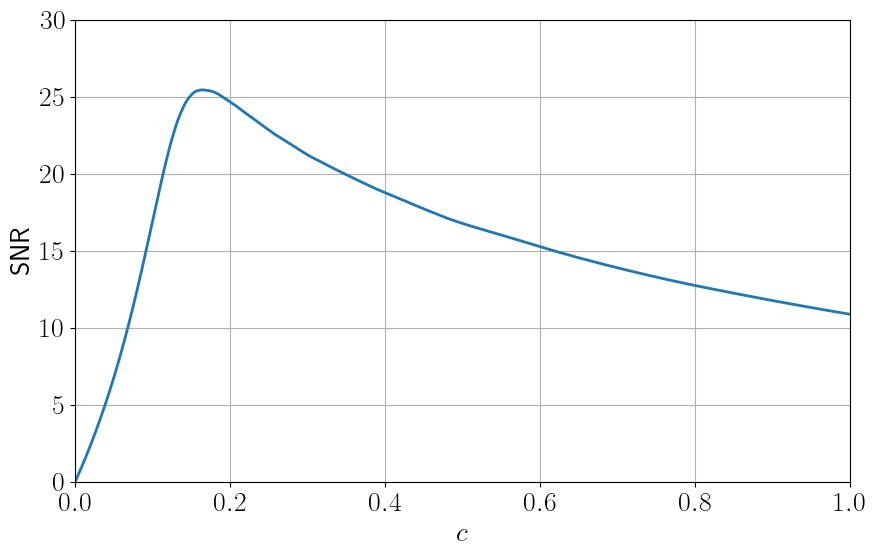

In [11]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(10,6))
plt.plot(c_range, SNRs,linewidth=2)
plt.xlim((0,1))
plt.ylim((0,30))
plt.grid()
plt.xlabel('$c$')
plt.ylabel('SNR')
#plt.savefig('AQF_optimalc_w%d.pdf' % w, bbox_inches='tight')

To find the optimal $c$, we employ the [Golden-section search](https://en.wikipedia.org/wiki/Golden-section_search). This algorithm finds the maximum over a unimodal function $f(x)$ (i.e., a function with a single maximum) over an interval $[x_1, x_4]$. Let $\varphi = \frac{1+\sqrt{5}}{2} \approx 1.618$ denote the golden ratio.

The algorithm works as follows:
1. Let 
\begin{align*}
x_2 &= x_4 - \frac{x_4-x_1}{\varphi}\\
x_3 &= x_1 + \frac{x_4-x_1}{\varphi}
\end{align*}
2. If $f(x_2) > f(x_3)$, then $x_4 \leftarrow x_3$, otherwise $x_1 \leftarrow x_2$. Then recompute
\begin{align*}
x_2 &= x_4 - \frac{x_4-x_1}{\varphi}\\
x_3 &= x_1 + \frac{x_4-x_1}{\varphi}
\end{align*}
3. If $|x_2-x_3| > \epsilon$, repeat step 2.

The final value $x_{\text{opt}}$ is obtained as $\frac{1}{2}(x_1+x_4)$.

In [12]:
c1 = 0.1
c4 = 50
phi = (1+np.sqrt(5))/2

c2 = c4 - (c4-c1)/phi
c3 = c1 + (c4-c1)/phi

while np.abs(c4-c1) > 1e-5:
    xh,_ = AQF(x,c2)
    SNR2 = 10*np.log10(np.mean(np.square(x))) - 10*np.log10(np.mean(np.square(x[0:len(xh)]-xh)))
    
    xh,_ = AQF(x,c3)
    SNR3 = 10*np.log10(np.mean(np.square(x))) - 10*np.log10(np.mean(np.square(x[0:len(xh)]-xh)))    
    
    if SNR2 > SNR3:
        c4 = c3
    else:
        c1 = c2
    
    c2 = c4 - (c4-c1)/phi
    c3 = c1 + (c4-c1)/phi

# compute final optimizer
c_opt = (c1+c4)/2
print(c_opt)

0.16368904443916152


Carry out quantization for optimal $c$

In [13]:
# fix x_max based on the current signal, leave some room
xh_AQF, Delta_AQF = AQF(x,c_opt)

In [14]:
# Compute segmental SNR
x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_AQF[0:segments*seg_len],(segments,seg_len))
snr_AQF_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

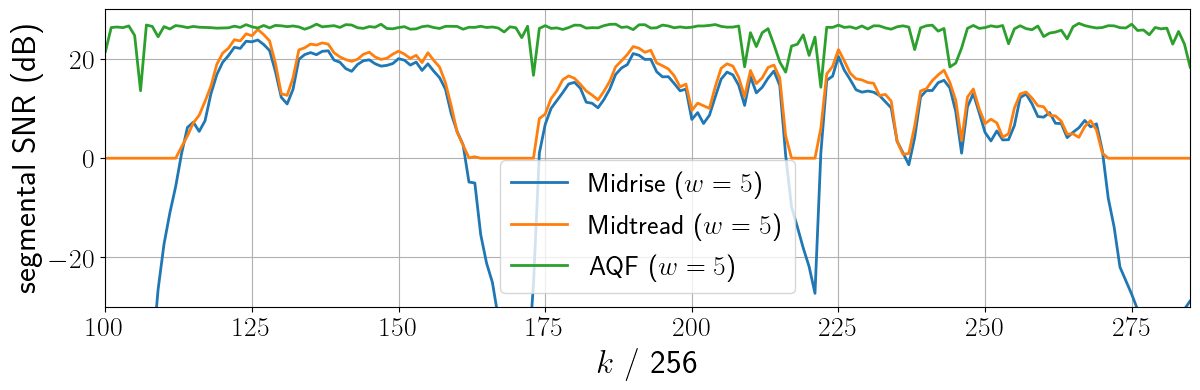

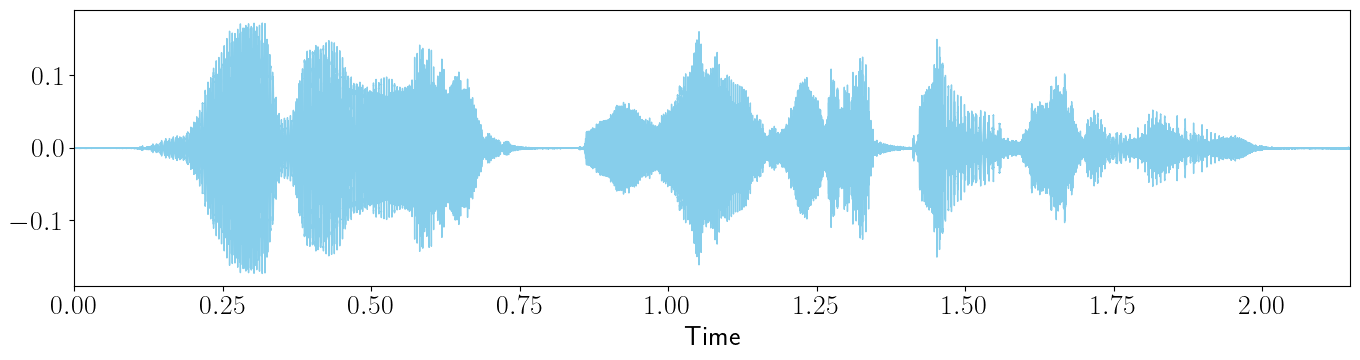

In [15]:
# plot segmental snr
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(14, 8.5))
plt.subplot(2,1,1)
plt.plot(np.arange(segments), snr_uniform_midrise_seg, linewidth=2)
plt.plot(np.arange(segments), snr_uniform_midtread_seg, linewidth=2)
plt.plot(np.arange(segments), snr_AQF_seg, linewidth=2)
plt.xlabel('$k$ / %d' % seg_len, fontsize=24)
plt.ylabel('segmental SNR (dB)', fontsize=24)
plt.ylim((-30,30))
plt.grid()

x_start = 25600 // seg_len
x_stop = 72960 // seg_len

plt.xlim((x_start,x_stop))
plt.legend(['Midrise ($w=5$)','Midtread ($w=5$)','AQF ($w=5$)'])

#plt.subplot(2,1,2)
audio_display_waveshow(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

#plt.savefig('AQF_segmentalSNR_w%d.pdf' % w, bbox_inches='tight')

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Schmalen\AppData\Local\Temp\ipykernel_29936\4014240897.py:12: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta[k]$', fontsize=24)


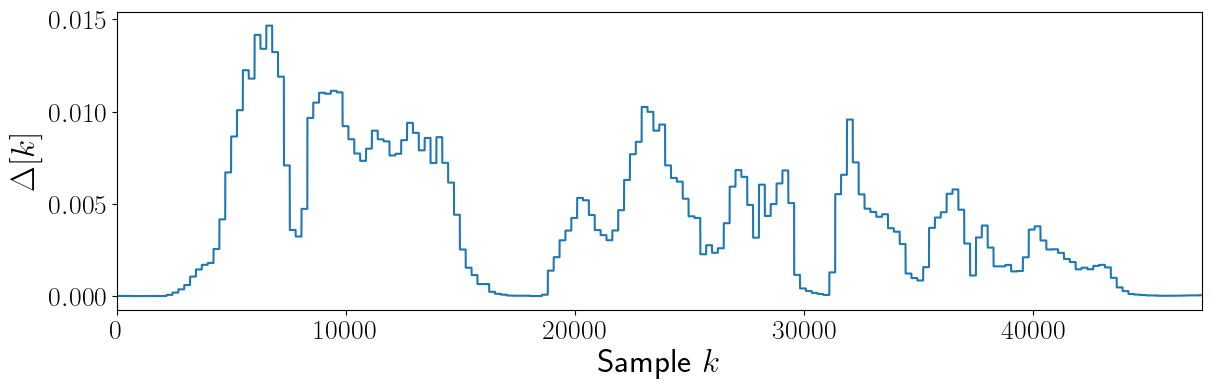

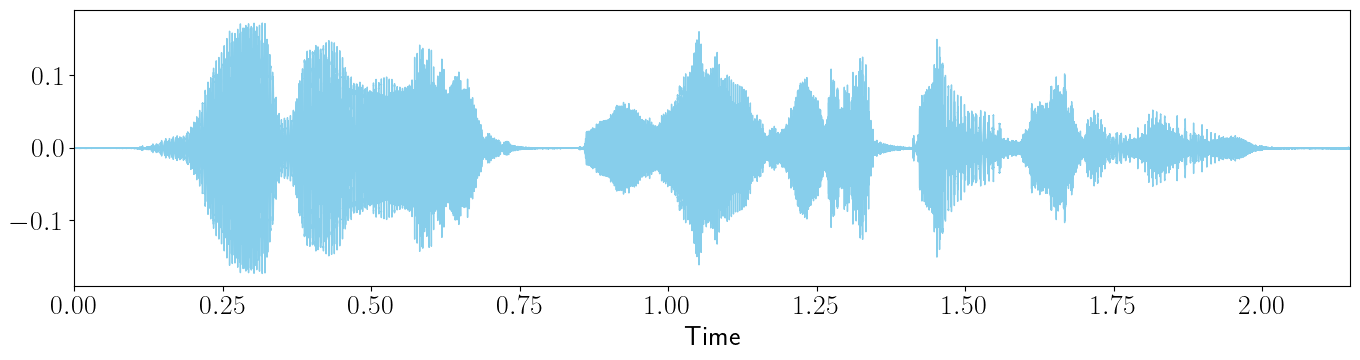

In [16]:
# plot stepsize
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(14, 8.5))

plt.subplot(2,1,1)
plt.plot(Delta_AQF[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)])
plt.xlim((0,(x_stop-x_start)*seg_len))
plt.xlabel('Sample $k$', fontsize=24)
plt.ylabel(r'$\Delta[k]$', fontsize=24)

#plt.subplot(2,1,2)
audio_display_waveshow(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

#plt.savefig('AQF_segmentalDelta_w%d.pdf' % w, bbox_inches='tight')

### Adaptive Quantization with Backward Estimation (AQB)

The AQB algorithm works on recursive computation of new stepsizes $\Delta[k] = M[k]\cdot \Delta[k-1]$
Quantization of $x[k]$ happens according to
$$
	\hat{x}[k] = \mathrm{sign}(x[k])\cdot Z[k]\cdot \frac{\Delta[k]}{2}
$$
with 
$$
Z[k] = 2 \left\lfloor\frac{x[k]}{\Delta[k]}\right\rfloor+1
$$
The new new stepsize $M[k+1]$ is usually obtained as
$$
	M[k+1] = \sqrt{\alpha + (1-\alpha)Z^2[k]\frac{c^2}{4}}
$$
where $\alpha$ and $c$ are parameters that need to be optimized. Here we use the tables from [Jay73]


[Jay73] N. S. Jayant, "Adaptive Quantization With a One-Word Memory," _Bell System Technical Journal_ , vol. 52, no. 7, pp. 1119--1144, 1973

In [17]:
M_dict = {2: [0.6, 2.2],
          3: [0.85, 1.0, 1.0, 1.5],
          4: [0.8, 0.8, 0.8, 0.8, 1.2, 1.6, 2.0, 2.4],
          5: [0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]}

def AQB(x, w):
    if w in M_dict:
        Ms = M_dict[w]
        
        q_max = 2**(w-1)-1
        
        # initial stepsize 0.1, needs to be known at transmitter and receiver
        # initial multiplier 1
        Delta = 0.1
        M = 1
        
        xh = np.sign(x) # precompute signs
        Deltas = np.zeros_like(x)
        
        for k in range(len(x)):
            # compute new stepsize
            Delta = Delta * M            
            Deltas[k] = Delta
            
            # quantize, this is the operation done at the transmitter, q is being transmitter
            q = int(np.floor(np.abs(x[k])/Delta))            
            # saturate
            if q < 0:
                q = 0
            if q > q_max:
                q = q_max
            
            # reconstruct sample, this is the receiver operation
            xh[k] *= (2*q+1)*Delta/2
            
            # compute new multiplier
            M = Ms[q]
        
        return xh, Deltas
    else:
        print('AQB not defined for word length w = %d' % w)
        return [],[]

xh_AQB,Delta_AQB = AQB(x,5)


In [18]:
# Compute segmental SNR
x_seg = np.reshape(x[0:segments*seg_len],(segments,seg_len))
xh_seg = np.reshape(xh_AQB[0:segments*seg_len],(segments,seg_len))
snr_AQB_seg = 10*np.log10(np.mean(np.square(x_seg),axis=1) / np.mean(np.square(xh_seg - x_seg),axis=1))

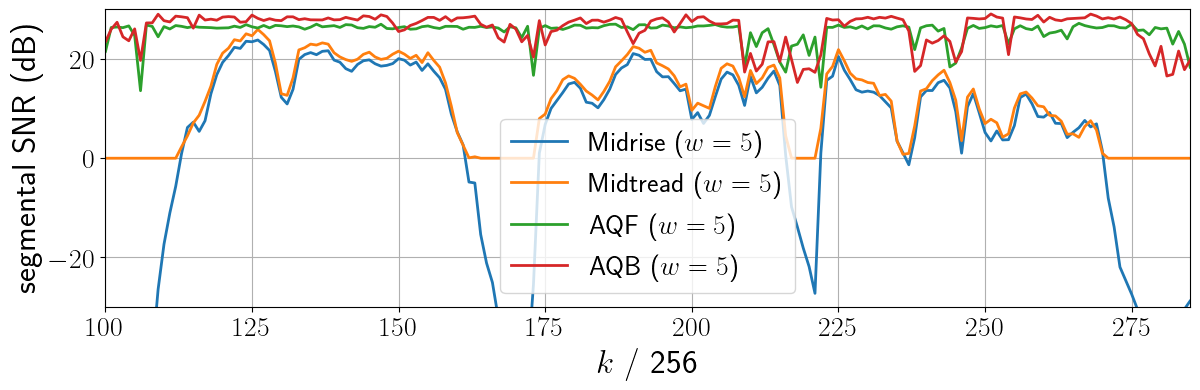

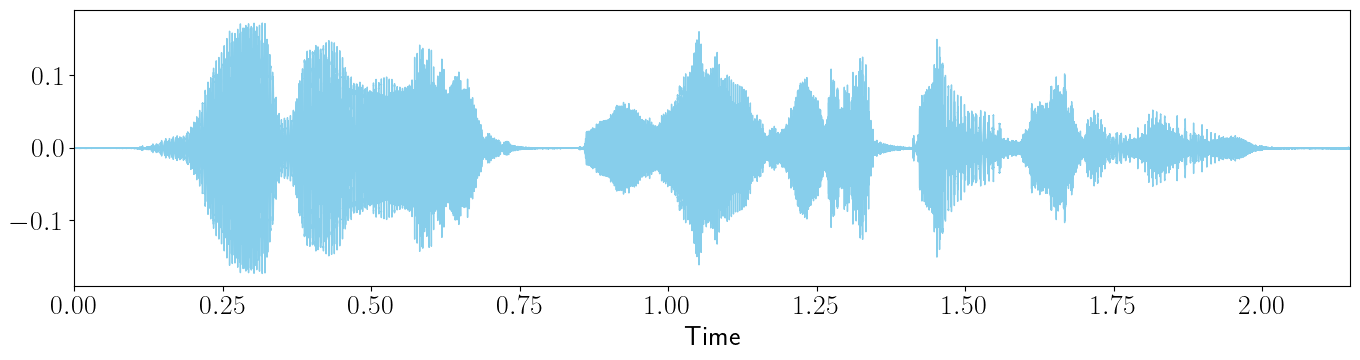

In [19]:
## plot segmental snr
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(14, 8.5))
plt.subplot(2,1,1)
plt.plot(np.arange(segments), snr_uniform_midrise_seg, linewidth=2)
plt.plot(np.arange(segments), snr_uniform_midtread_seg, linewidth=2)
plt.plot(np.arange(segments), snr_AQF_seg, linewidth=2)
plt.plot(np.arange(segments), snr_AQB_seg, linewidth=2)
plt.xlabel('$k$ / %d' % seg_len, fontsize=24)
plt.ylabel('segmental SNR (dB)', fontsize=24)
plt.ylim((-30,30))
plt.grid()

x_start = 25600 // seg_len
x_stop = 72960 // seg_len

plt.xlim((x_start,x_stop))
plt.legend(['Midrise ($w=5$)','Midtread ($w=5$)','AQF ($w=5$)', 'AQB ($w=5$)'])

#plt.subplot(2,1,2)
audio_display_waveshow(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

#plt.savefig('AQB_segmentalSNR_w%d.pdf' % w, bbox_inches='tight')

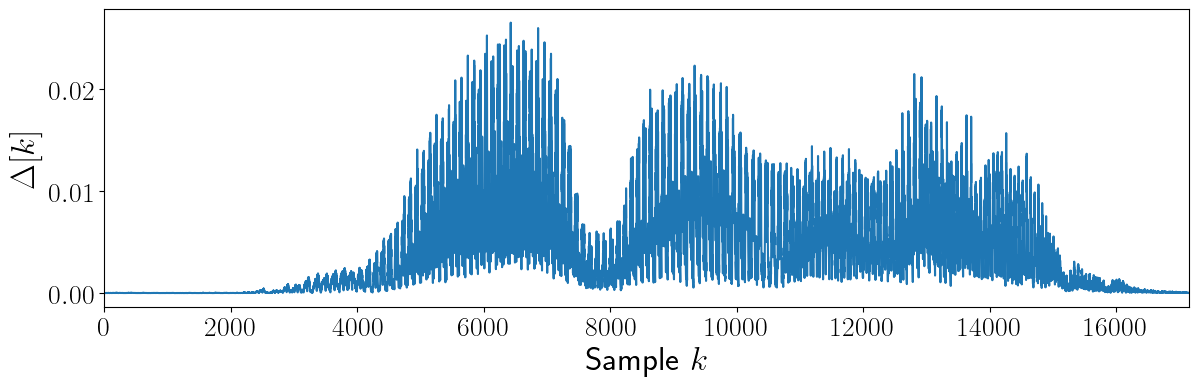

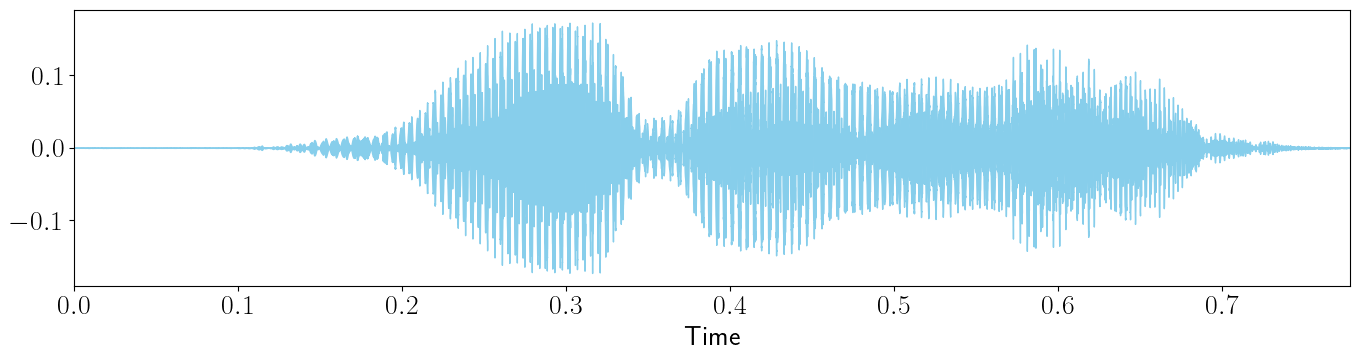

In [21]:
# plot stepsize of speech segement ("we will not")
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

plt.figure(figsize=(14, 8.5))

x_start = 25600 // seg_len
x_stop = 42960 // seg_len

plt.subplot(2,1,1)
plt.plot(Delta_AQB[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)])
plt.xlim((0,(x_stop-x_start)*seg_len))
plt.xlabel('Sample $k$', fontsize=24)
plt.ylabel(r'$\Delta[k]$', fontsize=24)

#plt.subplot(2,1,2)
audio_display_waveshow(x[(x_start*seg_len+seg_len//2):(x_stop*seg_len+seg_len//2)], sr=sampling_rate)
plt.tight_layout()

#plt.savefig('AQB_segmentalDelta_w%d.pdf' % w, bbox_inches='tight')